## Intro

In this notebook, we make Monte Carlo simulations of **windowed** power spectra for a few choices of spins: (l1,l2) = (0,0), (0,1), and (1,1), and find that the result depends on the spin, and find large wide-angle corrections for a realistic (SDSS) survey geometry. In each Monte Carlo iteration:

  - We simulate the linear density field (delta) and radial velocity field (v_r) in a periodic box.
  - We apply a survey window, i.e. restrict (delta, v_r) to the SDSS footprint.
  - We estimate the power spectra P_{delta,delta}(k), P_{delta,vr}(k), and P_{vr,vr}(k), using power spectrum estimators with "spins" (0,0), (0,1), and (1,1) respectively.
  - For simplicity, we use a "snapshot" geometry at z=0 (i.e. no lightcone evolution). (I think that fixing this would just be a matter of multiplying 'delta' by the growth function D(z) along the lightcone, and multiplying 'v_r' by faHD.)

This could be a starting point for working on computing (and deconvolving) the window function, using the approach in the overleaf notes "Wide-angle corrections to all orders".

This notebook is also intended to illustrate use of the 'kszx' library:

  - https://github.com/kmsmith137/kszx
  - https://kszx.readthedocs.io/

especially these classes/functions:

  - [Box class](https://kszx.readthedocs.io/en/latest/box.html)
  - [Cosmology class](https://kszx.readthedocs.io/en/latest/cosmology.html)
  - [Catalog class](https://kszx.readthedocs.io/en/latest/catalog.html)
  - [FFT wrappers](https://kszx.readthedocs.io/en/latest/fft.html), including "spin-1" versions.
  - [grid_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.grid_points)
  - [multiply_kfunc()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.multiply_kfunc)
  - [simulate_gaussian_field()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.simulate_gaussian_field)
  - [estimate_power_spectrum()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.estimate_power_spectrum)

The kszx library is currently in an "initial draft" state -- please feel free to suggest (or make!) changes!

## Imports and global variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kszx

In [2]:
# Number of Monte Carlo sims
nmc = 100 

# k-bins used for power spectrum estimation
nkbins = 25
kbin_edges = np.linspace(0, 0.1, nkbins+1)
kbin_centers = (kbin_edges[1:] + kbin_edges[:-1]) / 2.

In [3]:
# Every cosmologist defines their own CAMB wrapper class.
# Here is mine: https://kszx.readthedocs.io/en/latest/cosmology.html
# Note that I use Mpc everywhere, not (h^{-1} Mpc).

cosmo = kszx.Cosmology('planck18+bao')

Initializing 'planck18+bao' cosmology
Running CAMB
Done running CAMB [1.5206425189971924 seconds]


## Survey geometry

In this toy notebook, we choose to represent the survey geometry as follows:
 - Read the SDSS randoms (CMASS_North) from disk (by calling [kszx.sdss.read_randoms()](https://kszx.readthedocs.io/en/latest/sdss.html#kszx.sdss.read_randoms)).
 - Create a bounding box around the SDSS randoms (with 500 Mpc padding and pixel size 15 Mpc) by calling the [kszx.BoundingBox constructor](https://kszx.readthedocs.io/en/latest/boundingbox.html).
 - In the rest of the notebook, all "field-level" operations (e.g. FFTs) operate within the bounding box, using periodic boundary conditions.
 - We convert the SDSS randoms to a real-space density field (``rcat_real_space``) within the bounding box, by "gridding" the randoms with a CIC kernel ([kszx.grid_points()](https://kszx.readthedocs.io/en/latest/interpolation.html#kszx.grid_points)). In the rest of the notebook, whenever we want to restrict a real-space field to the survey footprint, we simply multiply the field by ``rcat_real_space``.


In [4]:
# kszs.sdss.read_randoms() returns a kszx.Catalog object.
# We'll just use the Catalog object temporarily, to compute Cartesian ("xyz") coordinates for each random.

# Note that we specify 'download=True' when calling kszx.sdss.read_randoms(). If the SDSS randoms have
# not been downloaded yet, then kszx.sdss.read_randoms() will auto-download the files.

rcat = kszx.sdss.read_randoms('CMASS_North', download=True)
rcat.apply_redshift_cut(0.43, 0.7)
print(rcat)

kszx: environment variable $KSZX_DATA_DIR not defined, using /home/kmsmith/kszx_data instead
Reading /home/kmsmith/kszx_data/sdss/DR12v5/random0_DR12v5_CMASS_North.fits
Read 32151741 galaxies from /home/kmsmith/kszx_data/sdss/DR12v5/random0_DR12v5_CMASS_North.fits, columns ['ra_deg', 'dec_deg', 'z']
Reading /home/kmsmith/kszx_data/sdss/DR12v5/random1_DR12v5_CMASS_North.fits
Read 32151250 galaxies from /home/kmsmith/kszx_data/sdss/DR12v5/random1_DR12v5_CMASS_North.fits, columns ['ra_deg', 'dec_deg', 'z']
Redshift cut: zmin=0.43 zmax=0.7: 64302991 -> 59175065 [92.025% retained]
Catalog(name=CMASS_North randoms, size=59175065, col_names=['ra_deg', 'dec_deg', 'z'])


In [5]:
# 'rcat_xyz' is a catalog object with three columns: ra_deg, dec_deg, z.
# We convert from spherical polar to Cartesian coordinates by calling Catalog.get_xyz().
# The return value of Catalog.get_xyz() is a numpy array with shape (N_rand, 3).

rcat_xyz = rcat.get_xyz(cosmo)

In [6]:
# Compute a Box which bounds the catalog.
# With these parameters (pixel size 15 Mpc, padding 500 Mpc), 
# the box dimensions are (216, 384, 216) and the box size is (3240, 5760, 3240) Mpc.

box = kszx.BoundingBox(rcat_xyz, pixsize=15, rpad=500)
print(box)

BoundingBox(
    npix = [216 384 216],
    pixsize = 15.0,
    boxsize = [3240. 5760. 3240.],
    kfund = [0.00193925 0.00109083 0.00193925],
    knyq = 0.20943951023931953,
    lpos = [-2980.88860096 -2932.6527411   -492.57298616],
    cpos = [-1368.38860096   -60.1527411   1119.92701384],
    rpos = [ 244.11139904 2812.3472589  2732.42701384]
    rpad = 500.00,
    rmin = 1706.22, rmax = 2579.23,
    npix_prepad = [162 310 171],
    npix_preround = [195 343 205]
)



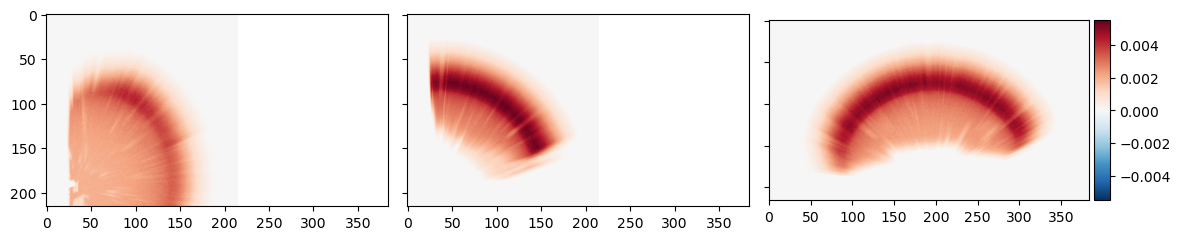

In [7]:
# Convert the randoms to a real-space map (represented as a shape-(216,384,216) numpy array).

rcat_real_space = kszx.grid_points(box, rcat_xyz, kernel='cic')
kszx.plot.real_space_plotter(rcat_real_space)

## Set up simulations

Here, we just define two functions ``simulate_fields()`` and ``simulate_power_spectra()`` which perform one Monte Carlo simulation.

One key step here is computing the **radial** velocity field v_r from the linear density field delta_lin. This frequently-occuring sequence of operations has been packaged up as the "spin-1 c2r" Fourier transform ``kszx.fft_c2r(..., spin=1)``. 

Similarly, another key step is **anisotropic** power spectrum estimation. Starting from the density field delta and radial velocity v_r, we want to estimate auto and cross power spectra P_{delta,delta}(k), P_{delta,vr}(k), and P_{vr,vr}(k).

The complication is that v_r is a non-scalar quantity, so we want to use an anisotropic power spectrum estimator. This frequently-occuring sequence of operations has been packaged up as the "spin-1 r2c" Fourier transform ``kszx.fft_r2c(..., spin=1)``. To estimate all auto and cross spectra, we simply call ``kszx.fft_r2c(delta, spin=0)`` and ``kszx.fft_r2c(vr spin=1)`` to get Fourier-space maps. Then we estimate P_{delta,delta}(k), P_{delta,vr}(k), and P_{vr,vr}(k) from the Fourier-space maps, in a straightforward way (by calling [kszx.estimate_power_spectrum()](https://kszx.readthedocs.io/en/latest/manipulating_maps.html#kszx.estimate_power_spectrum)). This procedure gives the correct anisotropic power spectrum estimators, with spins (0,0), (0,1), and (1,1) respectively, for P_{delta,delta}(k), P_{delta,vr}(k), and P_{vr,vr}(k).

For more info on "spin-1" transforms, see https://kszx.readthedocs.io/en/latest/fft.html.

In [8]:
def simulate_fields():
    """Simulates the density field 'delta' and the radial velocity field 'vr'.
    
    Returns a pair of real-space maps (delta_obs_real_space, vr_obs_real_space),
    where _obs_ means "restricted to the survey footprint". For simplicity, we
    use a 'snapshot' geometry at z=0, rather than applying factors D(z) and faH(z)
    along the lightcone."""
    
    # Simulate delta0 in Fourier space, by calling kszx.simulate_gaussian_field().
    # Note: 'delta0' denotes the field in the full bounding box, and 'delta_obs' denotes
    # the field after restricting to the survey footprint.
    
    delta0_fourier_space = kszx.simulate_gaussian_field(box, lambda k: cosmo.Plin_z0(k))
    delta_obs_real_space = kszx.fft_c2r(box, delta0_fourier_space)
    delta_obs_real_space *= rcat_real_space
    
    # Compute radial velocity vr from linear density field delta0, in two steps:
    #   - compute the scalar quantity v0(k) = (faH/k) delta(k), by calling kszx.multiply_kfunc().
    #   - apply a "spin-1" FFT kszx.fft_c2r(..., spin=1).
    
    faH0 = cosmo.frsd(z=0) * cosmo.H(z=0)
    v0_fourier_space = kszx.multiply_kfunc(box, delta0_fourier_space, lambda k:faH0/k, dc=0)
    vr_obs_real_space = kszx.fft_c2r(box, v0_fourier_space, spin=1)  # Note spin=1 here!!
    vr_obs_real_space *= rcat_real_space

    return delta_obs_real_space, vr_obs_real_space

In [9]:
def simulate_power_spectra():
    """Simulates (delta,vr) and estimates P_{delta,delta}(k), P_{delta,vr}(k), and P_{vr,vr}(k).

    Returns a shape (2,2,nkbins) array 'pk', where:
      pk[0,0,:] = auto power spectrum P_{delta,delta}(k)
      pk[1,1,:] = auto power spectrum P_{vr,vr}(k), computed with a spin-(1,1) anisotropic power spectrum estimator.
      pk[0,1,:] = cross power P_{delta,vr}(k), computed with a spin-(0,1) anisotropic power spectrum estimator.
    """

    # Real-space maps.
    delta_obs_real_space, vr_obs_real_space = simulate_fields()

    # Convert to Fourier-space maps, and estimate power spectra:
    #  - We call kszx.fft_r2c(..., spin=0) for 'delta', and kszx.fft_r2c(..., spin=1) for 'vr'.
    #  - Then we estimate auto and cross spectra from the Fourier-space maps, in a straightforward way.
    #  - This procedure gives the correct anisotropic power spectrum estimators, 
    #      with spins (0,0), (0,1), and (1,1) respectively, for P_{delta,delta}(k),
    #      P_{delta,vr}(k), and P_{vr,vr}(k).
    
    delta_obs_fourier_space = kszx.fft_r2c(box, delta_obs_real_space)
    vr_obs_fourier_space = kszx.fft_r2c(box, vr_obs_real_space, spin=1)   # note spin=1 here
    pk = kszx.estimate_power_spectrum(box, [delta_obs_fourier_space, vr_obs_fourier_space], kbin_edges)

    # Note: kszx.estimate_power_spectrum() returns a shape (2,2,nkbins) array as described in the docstring.
    return pk

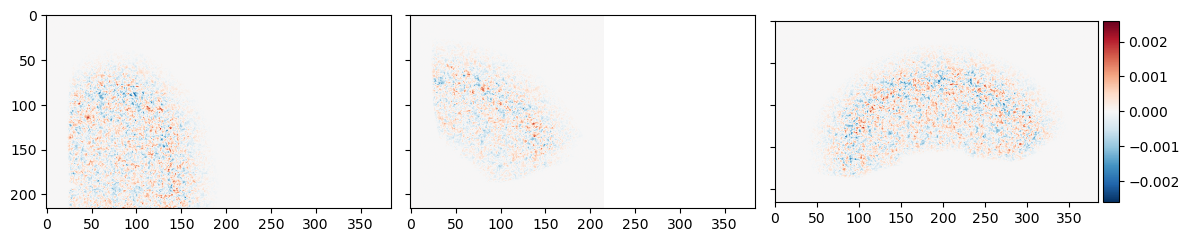

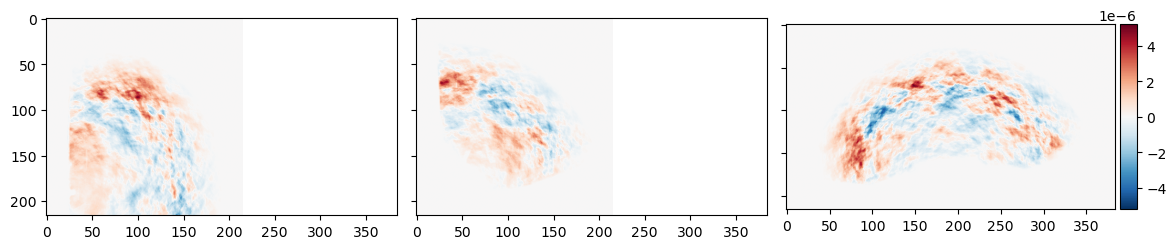

In [10]:
# Plot one sim, just for illustrative purposes (delta on top row, v_r on bottom row)

delta, vr = simulate_fields()
kszx.plot.real_space_plotter(delta)
kszx.plot.real_space_plotter(vr)

## Run 100 sims (This takes ~4 mins on my 32-core desktop)

In [ ]:
%%time

# Put all 100 power spectrum estimates into a single array pk_mcs, with shape (nmc, 2, 2, nkbins).
#   pk[:,0,0,:] = auto power spectra P_{delta,delta}(k)
#   pk[:,1,1,:] = auto power spectra P_{vr,vr}(k), computed with a spin-(1,1) anisotropic power spectrum estimator.
#   pk[:,0,1,:] = cross power P_{delta,vr}(k), computed with a spin-(0,1) anisotropic power spectrum estimator.

pk_mcs = np.array([ simulate_power_spectra() for _ in range(nmc) ])

## Plot power spectra
  - In the previous step, we estimated P_{delta,delta}(k), P_{delta,vr}(k), and P_{vr,vr}(k).
  - Here, we plot the following quantities on the same axes:
      - P_{delta,delta}(k)
      - 3 * (k/faH) P_{delta,vr}(k)
      - 5 * (k/faH)^2 P_{vr,vr}(k)
  - In the distant-observer approximation, all 3 of these curves would be on top of each other. In the plot, we do see significant (compared to error bars) differences at low k. **Therefore, spin-dependent wide-angle corrections are important.** This plot could be a starting point for working on computing (and deconvolving) the window function, using the approach in the overleaf notes "Wide-angle corrections to all orders".
  - Error bars in the plot include a factor 1/sqrt(100) from 100 Monte Carlo sims.
  - Overall normalization of P(k) is arbitrary (I just didn't bother keeping track of it in this toy notebook). (I think the normalization is wrong by roughly N_rand^2 / (Vsurvey * Vbox) ~ 10^{-5}.)

In [ ]:
faH0 = cosmo.frsd(z=0) * cosmo.H(z=0)

plt.errorbar(kbin_centers, np.mean(pk_mcs[:,0,0,:],axis=0), 
             yerr = np.std(pk_mcs[:,0,0,:],axis=0)/nmc**0.5, 
             label = r'$P_{\delta\delta}(k)$')

plt.errorbar(kbin_centers, 
             y = 3 * (kbin_centers/faH0) * np.mean(pk_mcs[:,0,1,:],axis=0), 
             yerr = 3 * (kbin_centers/faH0) * np.std(pk_mcs[:,0,1,:],axis=0)/nmc**0.5, 
             label = r'$3 (k/faH) P_{\delta v_r}(k)$')


plt.errorbar(kbin_centers, 
             y = 5 * (kbin_centers/faH0)**2 * np.mean(pk_mcs[:,1,1,:],axis=0), 
             yerr = 5 * (kbin_centers/faH0)**2 * np.std(pk_mcs[:,1,1,:],axis=0)/nmc**0.5, 
             label = r'$5 (k/faH)^2 P_{v_r v_r}(k)$')

plt.title('Comparison between windowed power spectra with different spins')
plt.xlabel(r'Wavenumber $k$ (Mpc$^{-1}$)')
plt.ylabel(r'$P(k)$ [arbitrary normalization]')
plt.legend(loc='upper right')
plt.show()